<h1>US Solar Panel Installation Analysis</h1>


In [1]:
#Dependencies
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import requests
from census import Census
from us import states
import gmaps
import seaborn as sns
import scipy.stats as stats
from config import gmk, ckey

#API Keys
gmaps.configure(api_key=gmk)
ck=ckey


<h2>Import the Data - <i>API & CSV</i></h2>

In [2]:
#API Pull Census
def census(year):
    # Census API Key
    c = Census(ck, year=year)
    # Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
    # See: https://github.com/CommerceDataService/census-wrapper for library documentation
    # See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), {'for': 'zip code tabulation area:*'})

    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

    # Column Renaming
    census_pd = census_pd.rename(columns={"B01003_001E": "population", 
                                      "B01002_001E": "median age",
                                      "B19013_001E": "household income",
                                      "B19301_001E": "per capita income",
                                      "B17001_002E": "poverty count",
                                      "zip code tabulation area": "zipcode"})

    # Add in Poverty Rate (Poverty Count / Population)
    census_pd["poverty rate"] = 100 * census_pd["poverty count"].astype(int) / census_pd["population"].astype(int)

    # Final DataFrame
    census_pd = census_pd[["zipcode", "population", "median age", "household income",
                       "per capita income", "poverty count", "poverty rate"]]

    #Add column for the year
    census_pd['year']=year
    return census_pd

#Combine the census data for the years of 2000-2015
census_list=list()
for year in range(2011, 2016):
    census_list.append(census(year))
census_df=census_list[0].append([census_list[i] for i in range(1,5)], ignore_index=True)
census_df=census_df.rename(index=str, columns={"year": "year_installed"})
census_df['zipcode']=census_df['zipcode'].astype('int')



#files
file_path1="openpv_all.csv"
df=pd.read_csv(file_path1, low_memory=False)
zc_filepath="zipcodelist.csv"
#See https://gist.github.com/erichurst/7882666#file-us-zip-codes-from-2013-government-data for source
zc=pd.read_csv(zc_filepath, low_memory=False)


In [3]:
df.head()

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,new_constr,effic_1,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty
0,TX,12/12/2013,Austin Energy,uir,10.56,NaN,78702.0,residential,NaN,2.897777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TX,07/11/2014,Austin Energy,uir,12.72,NaN,78702.0,residential,NaN,3.144654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,01/17/2014,Austin Energy,uir,5.40,NaN,78702.0,residential,NaN,4.197330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TX,09/27/2012,Austin Energy,uir,7.50,NaN,78702.0,residential,NaN,3.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TX,09/26/2012,Austin Energy,uir,5.00,NaN,78702.0,residential,NaN,3.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
zc.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [5]:
census_df.head()

,zipcode,population,median age,household income,per capita income,poverty count,poverty rate,year_installed
0,1001,16775,44.1,59453,28931,1428,8.512668,2011
1,1002,27684,23.8,54395,30110,5795,20.932669,2011
2,1003,11516,19.9,None,3483,0,0.000000,2011
3,1005,5045,42.8,74167,33510,223,4.420218,2011
4,1007,14479,40.5,75502,32898,660,4.558326,2011


<h2>US Solar Panel Installation Trend </h2>  Installations, Year

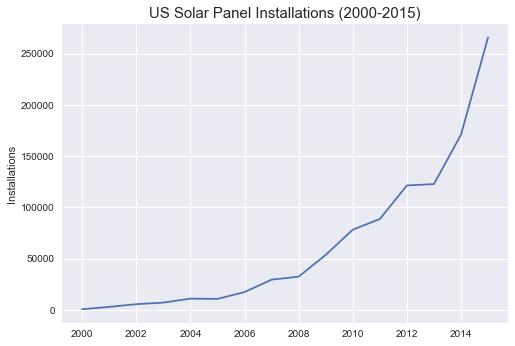

In [6]:
#Extract the years and months of the installation and added to the dataframe
df=df[pd.notnull(df['date_installed'])]
year_list=[]
month_list=[]
for date in df['date_installed'].values:

    year=str(date).split('/')[2]
    month=str(date).split('/')[0]
    year_list.append(int(year))
    month_list.append(int(month))

df['year_installed']=year_list
df['month_installed']=month_list

#National total installation change over the years
change_over_years=df.groupby('year_installed')['date_installed'].count()
change_over_years=pd.DataFrame(change_over_years)
change_over_years['percent change']=change_over_years['date_installed']/max(change_over_years['date_installed'].values)*100

change_over_years1=df.groupby('year_installed')['date_installed'].count().reset_index()
change_over_years1=pd.DataFrame(change_over_years1)
change_over_years1=change_over_years1[change_over_years1['year_installed'] > 1999]
change_over_years1=change_over_years1[change_over_years1['year_installed'] < 2016]
change_over_years1['percent change']=change_over_years1['date_installed']/max(change_over_years1['date_installed'].values)*100



change_over_years1
plt.ylabel('Installations')
plt.title("US Solar Panel Installations (2000-2015)", fontsize=15)
plt.plot(change_over_years1['year_installed'], change_over_years1['date_installed'])
plt.savefig("USSPI_Year.png", bbox_inches='tight')
plt.show()

final_df=pd.merge(df, census_df, how='left', on=['zipcode', 'year_installed'])  
new1_cols=final_df.columns.drop(['incentive_prog_names', 'type', 'size_kw', 'cost_per_watt', 'lbnl_tts_version_year', 'lbnl_tts', 'utility_clean', 'tech_1', 'annual_insolation', 'rebate', 'sales_tax_cost', 'tilt1', 'tracking_type',
                                 'azimuth1'])
final_df=final_df[new1_cols]
spp=pd.DataFrame(final_df)




<h2>Installations by State</h2>  Installations, State

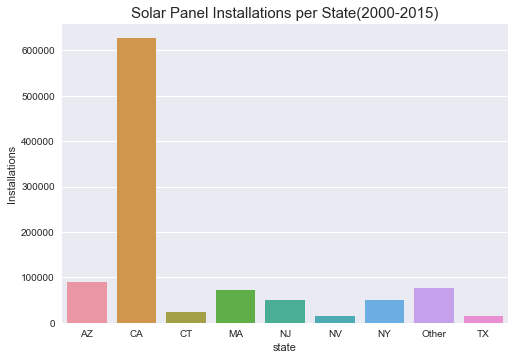

In [7]:
## Installations vs state
state_counts=df.groupby('state')['date_installed'].count()
state_counts1=df.groupby('state')['date_installed'].count().reset_index(name="installations")



state_counts1.loc[state_counts1['installations'] < 12000, 'state'] = "Other"

s = pd.DataFrame(state_counts1.groupby('state')['installations'].sum().reset_index())
s


#create barplot using seaborn
SP_IN_S=sns.barplot(x="state", y="installations", data=s)
plt.ylabel('Installations')
plt.title("Solar Panel Installations per State(2000-2015)", fontsize=15)
plt.savefig("SPInstalls_State.png", bbox_inches='tight')
plt.show(SP_IN_S)



<h2>US Installations - <i>Interactive Weighted Heatmap</i></h2>

In [8]:
zipcodes=final_df["zipcode"] 
#use for loops to add leading zeros for zipcodes for census data
zipcodes3 = [int(zipcode) for zipcode in zipcodes]
zipcodes3 = [str(zipcode) for zipcode in zipcodes3]
zipcodes3 = [str(zipcode).zfill(5) for zipcode in zipcodes3]

#groupby zipcode counts, sum instances to create a weight for the heatmap
zipcodes3=pd.DataFrame(zipcodes3)
zipcodes3
zipcodes3=zipcodes3.groupby(0)[0].count().reset_index(name="Weight")

zipcodes3 = zipcodes3.rename(columns={0:'Zipcode'})

zc = zc.rename(columns={'ZIP':'Zipcode','LAT':'Latitude','LNG':'Longitude'})

#use for loops to add leading zeros for zipcodes in zip file
zc['Zipcode'] = [int(zipcode) for zipcode in zc['Zipcode']]
zc['Zipcode'] = [str(zipcode) for zipcode in zc['Zipcode']]
zc['Zipcode'] = [str(zipcode).zfill(5) for zipcode in zc['Zipcode']]
zc.head()

#merge dataframe on key zipcode
result = pd.merge(zipcodes3, zc, how='left', on=['Zipcode'])
result=result.dropna() 
result.head()



,Zipcode,Weight,Latitude,Longitude
12,00778,1,18.264076,-65.978510
14,00960,1,18.416919,-66.145795
15,00969,1,18.368062,-66.108062
16,01001,133,42.062368,-72.625754
17,01002,589,42.364061,-72.458739


In [9]:
#set latitude and longitude weights
locations = result[["Latitude", "Longitude"]]
weights = result["Weight"]

#center image
latlong_dict=[]
us = (37.0902, -95.7129)

fig = gmaps.figure(center=us, zoom_level=4)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig



Figure()

<h1>Exploratory Analysis</h1>

<h3>National Total Installations -  Change Over Months</h3>

                 date_installed
month_installed                
1                         76016
2                         67403
3                         76449
4                         75967
5                         78350
6                         85066
7                         85228
8                         90754
9                         90665
10                        95539
11                        90224
12                       108792


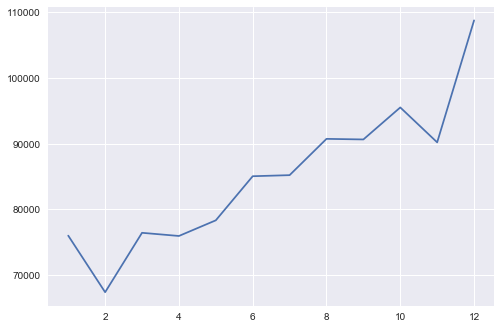

In [10]:
#National total installation change over the months
change_over_months=df.groupby('month_installed')['date_installed'].count()
print(pd.DataFrame(change_over_months))
plt.plot(change_over_months.index, change_over_months.values)
plt.show()

<h3>NJ Total Installations -  Change Over Years</h3>

                date_installed  percent change
year_installed                                
2001                         3        0.030288
2002                        40        0.403836
2003                       101        1.019687
2004                       307        3.099445
2005                       768        7.753660
2006                       932        9.409389
2007                       744        7.511358
2008                       943        9.520444
2009                      1500       15.143867
2010                      4785       48.308935
2011                      8506       85.875820
2012                      9445       95.355881
2013                      6546       66.087834
2014                      6514       65.764765
2015                      9905      100.000000
2016                         6        0.060575
2017                         1        0.010096


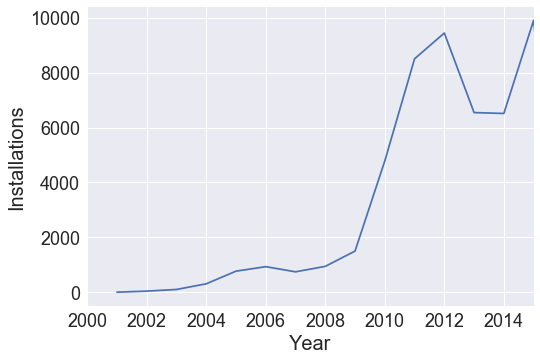

In [11]:
# Total installation change over the years in NJ
df_nj=df[df['state']=='NJ']
change_over_years_nj=df_nj.groupby('year_installed')['date_installed'].count()
change_over_years_nj=pd.DataFrame(change_over_years_nj)
change_over_years_nj['percent change']=change_over_years_nj['date_installed']/max(change_over_years_nj['date_installed'].values)*100
print(change_over_years_nj)
plt.plot(change_over_years_nj.index, change_over_years_nj['date_installed'])
plt.xlim(2000,2015)
plt.xlabel('Year', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Installations', fontsize=20)
plt.yticks(fontsize=18)
#plt.title('Installations Change over Years in NJ', fontsize=24)
#plt.legend()
plt.show()


<h3>NJ Total Installations -  Change Over Months</h3>

                 date_installed
month_installed                
1                          3835
2                          3553
3                          4178
4                          4077
5                          3815
6                          4264
7                          4711
8                          4463
9                          4091
10                         5183
11                         4088
12                         4788


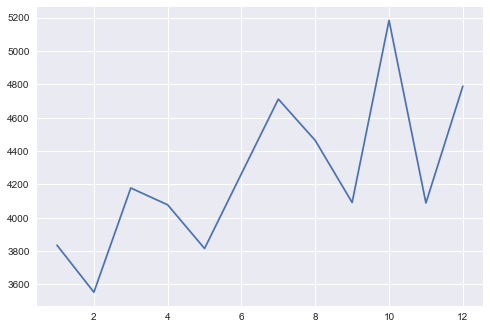

In [12]:
#Total installation change over the months in NJ
change_over_months_nj=df_nj.groupby('month_installed')['date_installed'].count()
print(pd.DataFrame(change_over_months_nj))
plt.plot(change_over_months_nj.index, change_over_months_nj.values)
plt.show()

<h3>NJ - Installations vs County</h3>

            county  percent change
Ocean         9205       18.039823
Monmouth      5173       10.137969
Middlesex     4844        9.493200
Burlington    4406        8.634814
Atlantic      3214        6.298750
Somerset      2682        5.256144
Camden        2475        4.850468
Gloucester    2223        4.356603
Bergen        2131        4.176302
Mercer        2072        4.060675
Morris        1882        3.688316
Essex         1585        3.106260
Union         1539        3.016109
Cape May      1450        2.841689
Hunterdon     1314        2.575158
Cumberland    1113        2.181241
Passaic       1077        2.110689
Sussex         726        1.422804
Salem          661        1.295418
Warren         652        1.277780
Hudson         602        1.179791


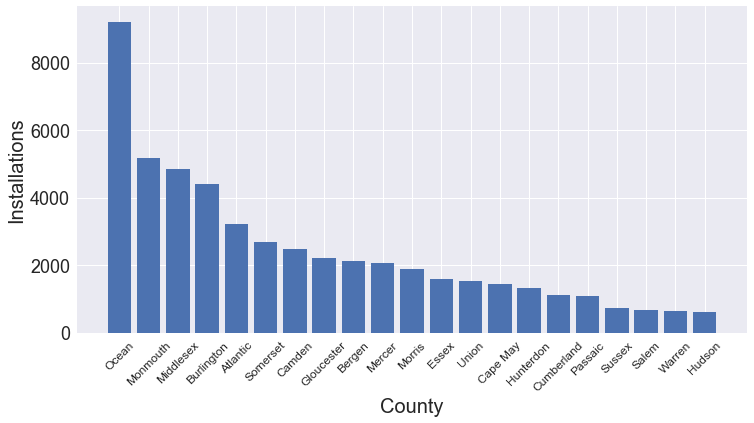

In [13]:
#Installations vs county in NJ
df_county_nj=df_nj['county'].value_counts()
df_county_nj=pd.DataFrame(df_county_nj)
df_county_nj['percent change']=df_county_nj['county']/sum(df_county_nj['county'].values)*100
print(df_county_nj)

#Installations vs county in NJ
plt.figure(figsize=(12,6))
plt.bar(range(len(df_county_nj)),df_county_nj['county'])
#plt.xlabel(df_county_nj.index), rotation=45)
plt.xticks(range(len(df_county_nj)), df_county_nj.index, fontsize=12, rotation=45)
plt.xlabel('County', fontsize=20)
plt.ylabel('Installations', fontsize=20)
#plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

<h3>NJ Total Installations -  Change Over Years</h3>

                date_installed
year_installed                
2002                         5
2003                        16
2004                        20
2005                       128
2006                        84
2007                        99
2008                        84
2009                       156
2010                       594
2011                      1597
2012                      2503
2013                      1031
2014                      1052
2015                      1836


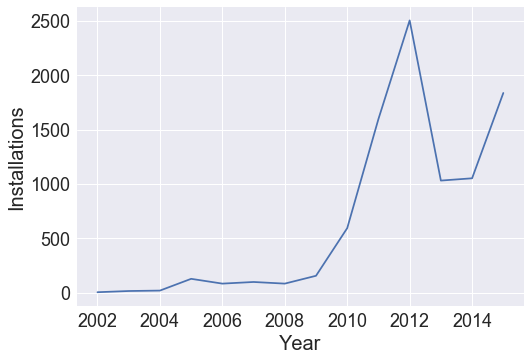

In [14]:
# Total installation change over the years in NJ
df_oc=df_nj[df_nj['county']=='Ocean']
change_over_years_oc=df_oc.groupby('year_installed')['date_installed'].count()
print(pd.DataFrame(change_over_years_oc))
plt.plot(change_over_years_oc.index, change_over_years_oc.values)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Installations', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

                 date_installed
month_installed                
1                           698
2                           579
3                           710
4                           694
5                           667
6                           733
7                           933
8                           939
9                           793
10                          912
11                          684
12                          863


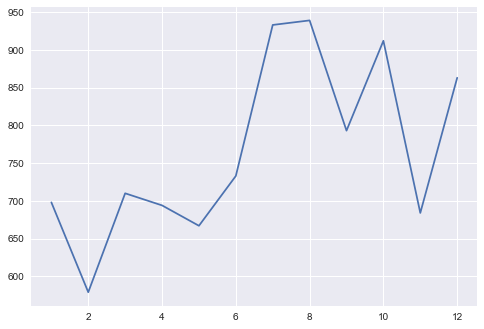

In [15]:
#Total installation change over the months in NJ
change_over_months_oc=df_oc.groupby('month_installed')['date_installed'].count()
print(pd.DataFrame(change_over_months_oc))
plt.plot(change_over_months_oc.index, change_over_months_oc.values)
plt.show()

In [16]:
#Define the function to extract the state-based census data for the years of 2011-2015
def census_state(year):
    # Census API Key
    c = Census(ckey, year=year)
    # Run Census Search to retrieve data on all states
    # Note the addition of "B23025_005E" for unemployment count
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_005E"), {'for': 'state:*'})

    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

    # Column Reordering
    census_pd = census_pd.rename(columns={"B01003_001E": "Population", 
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "NAME": "Name", "state": "State"})

    # Add in Poverty Rate (Poverty Count / Population)
    census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

    # Add in Employment Rate (Employment Count / Population)
    census_pd["Unemployment Rate"] = 100 * census_pd["Unemployment Count"].astype(int) / census_pd["Population"].astype(int)

    # Final DataFrame
    census_pd = census_pd[["State", "Name", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate", "Unemployment Rate"]]

    #Add column for the year
    census_pd['year']=year
    return census_pd

#Combine the state-based census data for the years of 2011-2015
census_list1=list()
for year in range(2011, 2016):
    census_list1.append(census_state(year))
census_state=census_list1[0].append([census_list1[i] for i in range(1,5)], ignore_index=True)

#Replace the full state names with abbreviations
new_cols2=census_state.columns.drop(['State'])
census_state=census_state[new_cols2]
census_state=census_state.rename(columns={'Name':'state'})
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
census_state=census_state.replace(us_state_abbrev)
census_state.head()


,state,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,year
0,AL,4747424,37.7,42934,23483,813385,17.133186,4.540210,2011
1,AK,700703,33.8,69014,31944,65111,9.292239,4.414424,2011
2,AZ,6337373,35.7,50752,25784,1003575,15.835820,4.234610,2011
3,AR,2895928,37.3,40149,21833,516822,17.846507,3.940015,2011
4,CA,36969200,35.1,61632,29634,5211481,14.096818,5.055211,2011


In [17]:

df_2015=final_df[final_df['year_installed']==2015] 
df_2015.head()
df1=pd.DataFrame(df_2015.groupby('state')['date_installed'].count())
df1=df1.rename(columns={'date_installed': 'ins. counts'})
census_state_2015=census_state[census_state['year']==2015]
df1=df1.reset_index()
census_state_2015
state_count_df=pd.merge(df1, census_state_2015, on='state', how='right')
state_count_df.head()

,state,ins. counts,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate,year
0,AL,1.0,4.83062e+06,38.4,43623,24091,887260,18.367415,4.287172,2015
1,AZ,17105.0,6.64193e+06,36.8,50255,25848,1.18069e+06,17.776314,4.151084,2015
2,CA,160045.0,3.84215e+07,35.8,61818,30318,6.13514e+06,15.968007,4.921939,2015
3,CO,6.0,5.27891e+06,36.3,60629,32217,653969,12.388343,3.704896,2015
4,CT,8342.0,3.59322e+06,40.4,70331,38803,366351,10.195613,4.794917,2015


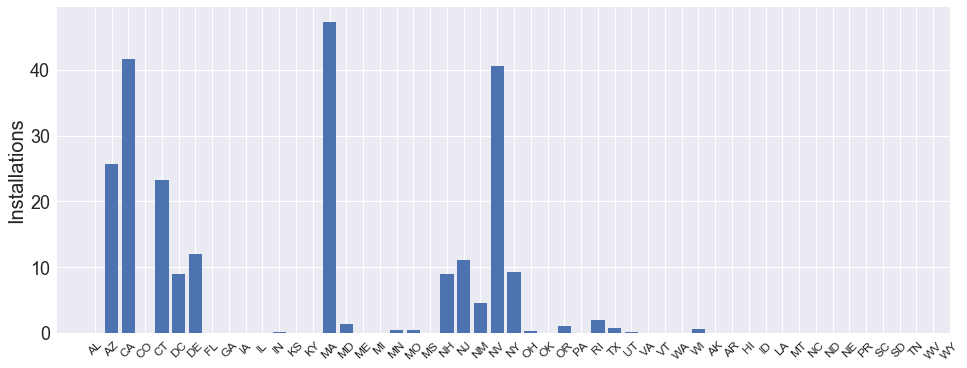

In [18]:
#plot state vs normalized counts (counts per 10,000 populations)
norm_counts=state_count_df['ins. counts']/state_count_df['Population'].astype(int)*10000
plt.figure(figsize=(16,6))
plt.bar(range(len(state_count_df)),norm_counts, label="2015")
#plt.xticks(x, labels, rotation='vertical')
plt.xticks(range(len(state_count_df)), state_count_df['state'], fontsize=12, rotation=45)
#plt.xlabel('State', fontsize=20)
#plt.xticks(fontsize=14)
plt.ylabel('Installations', fontsize=20)
plt.yticks(fontsize=18)
#plt.title('State vs Normalized Installations (2015)', fontsize=24)
#plt.legend()
plt.show()

In [19]:
df_2015=df_2015[['zipcode', 'date_installed','population','median age','household income']]
df_2015=df_2015.dropna()
len(df_2015)

264799

<h2>Population Analysis</h2>

In [20]:
#2015 data for scatter plot analysis
ins_counts_zip=df_2015.groupby('zipcode')['date_installed'].count()
pop_zip=df_2015.groupby('zipcode')['population'].unique()
age_zip=df_2015.groupby('zipcode')['median age'].unique()
income_zip=df_2015.groupby('zipcode')['household income'].unique()
#Generate the summary table for more analysis
df_zip=pd.DataFrame(ins_counts_zip)
df_zip['age']=age_zip.astype(int)
df_zip['population']=pop_zip.astype(int)
df_zip['household income']=income_zip.astype(int)
df_zip=df_zip.rename(columns={'date_installed':'ins counts'})
df_zip.head()


,ins counts,age,population,household income
zipcode,,,,
1001.0,76,44,17438,60161
1002.0,174,23,29780,50540
1005.0,51,43,5201,68786
1007.0,304,42,14838,76881
1008.0,6,49,1171,70417


In [21]:
#Calculate the correlation coefficiency
print(df_zip.corr())
min(pop_zip.astype(int))

                  ins counts       age  population  household income
ins counts          1.000000 -0.167640    0.454405          0.070810
age                -0.167640  1.000000   -0.459336          0.197061
population          0.454405 -0.459336    1.000000         -0.067173
household income    0.070810  0.197061   -0.067173          1.000000


43

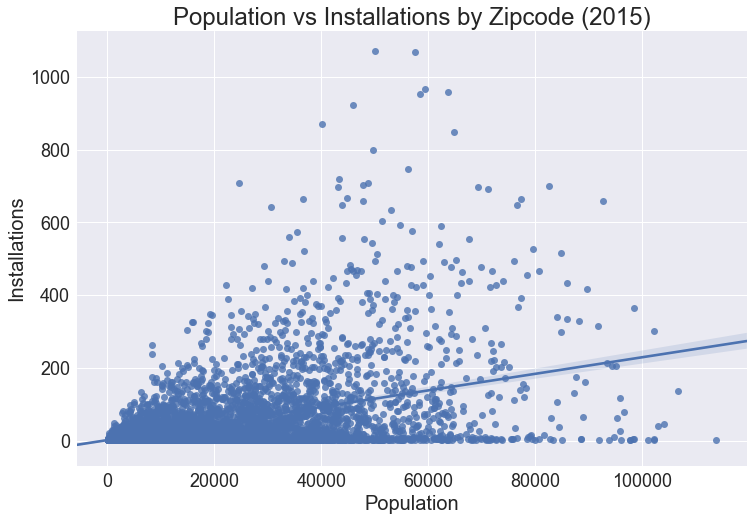

In [22]:
#plot population vs ins counts by zipcode
plt.figure(figsize=(12,8))
#plt.scatter(pop_zip.astype(int),ins_counts_zip, label="2015 by zipcode")
ax = sns.regplot(x=pop_zip.astype(int), y=ins_counts_zip)
#plt.xlim(0,2.6e7)
plt.xlabel('Population', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Installations', fontsize=20)
plt.yticks(fontsize=18)
plt.title('Population vs Installations by Zipcode (2015)', fontsize=24)
#plt.legend()
plt.show()

30.178047839506174
127.80028129395218
163.45794392523365


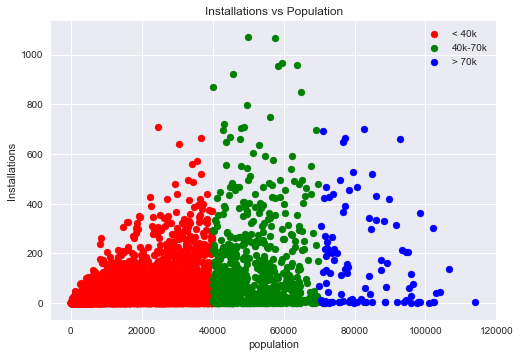

In [23]:
#Statistical Analysis for Population vs Installations
#Three subsets of the population group
df_zip_lt40kp=df_zip[df_zip['population']< 40000]
df_zip_40k_70kp=df_zip[(df_zip['population']>= 40000) & (df_zip['population'] < 70000)]
df_zip_gt70kp=df_zip[df_zip['population']>= 70000]
#Mean values
mean_lt40kp = df_zip_lt40kp['ins counts'].mean()
mean_40k_70kp=df_zip_40k_70kp['ins counts'].mean()
mean_gt70kp=df_zip_gt70kp['ins counts'].mean()
print(mean_lt40kp)
print(mean_40k_70kp)
print(mean_gt70kp)
# Plot the population vs installation data
plt.scatter(df_zip_lt40kp['population'], df_zip_lt40kp['ins counts'], c="r", label="< 40k")
plt.scatter(df_zip_40k_70kp['population'], df_zip_40k_70kp['ins counts'], c="g", label="40k-70k")
plt.scatter(df_zip_gt70kp['population'], df_zip_gt70kp['ins counts'], c="b", label="> 70k")
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("Installations")
plt.title("Installations vs Population")
plt.show()

In [24]:
# Perform the ANOVA
anova_pop=stats.f_oneway(df_zip_lt40kp['ins counts'],df_zip_40k_70kp['ins counts'],df_zip_gt70kp['ins counts'])
anova_pop

F_onewayResult(statistic=511.50428701940319, pvalue=7.7039032243146832e-206)

In [25]:
# Run 2-Sample T-Test: 40k vs 70k+ population
ttest_pop1=stats.ttest_ind(df_zip_lt40kp['ins counts'],df_zip_40k_70kp['ins counts'], equal_var=False)
ttest_pop1

Ttest_indResult(statistic=-14.752235001588431, pvalue=2.5625687065220282e-43)

In [26]:


# Run 2-Sample T-Test: 40k vs 70k+ population
ttest_pop2=stats.ttest_ind(df_zip_lt40kp['ins counts'],df_zip_gt70kp['ins counts'], equal_var=False)
ttest_pop2

Ttest_indResult(statistic=-7.2355486548060926, pvalue=7.497618789312924e-11)

In [27]:

# Run 2-Sample T-Test: 40k-70k vs 70k+ population
ttest_pop3=stats.ttest_ind(df_zip_gt70kp['ins counts'],df_zip_40k_70kp['ins counts'], equal_var=False)
ttest_pop3

Ttest_indResult(statistic=1.8250736812929107, pvalue=0.070210715958278824)

In [28]:

#Generate a dataframe to summarize the stats results for the population analysis
pop_gps=['< 40k','40-70k','> 70k']
stat_tests=['ANOVA', "2-Sample T-Test", "2-Sample T-Test", "2-Sample T-Test"]
groups=['<40k, 40-70k, >70k','<40k vs 40-70k', '<40k vs >70k', '40-70k vs >70k']
p_values=[anova_pop[1], ttest_pop1[1],ttest_pop2[1],ttest_pop3[1]]

stat_pop=pd.DataFrame({"Stat Test": stat_tests, "Groups": groups, "p Value": p_values})
stat_pop=stat_pop[['Stat Test','Groups','p Value']]
stat_pop['p Value']=stat_pop['p Value'].round(2)
stat_pop


,Stat Test,Groups,p Value
0,ANOVA,"<40k, 40-70k, >70k",0.00
1,2-Sample T-Test,<40k vs 40-70k,0.00
2,2-Sample T-Test,<40k vs >70k,0.00
3,2-Sample T-Test,40-70k vs >70k,0.07


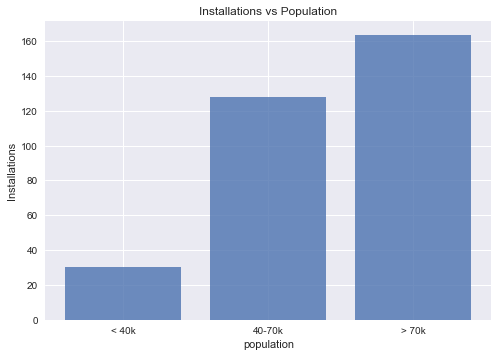

In [29]:
#Plot bar graph for the mean counts vs population groups
pop_gps=['< 40k','40-70k','> 70k']
#plt.bar(x_axis, users, color='r', alpha=0.5, align="edge")
tick_locations = [value+0.4 for value in range(3)]
plt.xticks(tick_locations, pop_gps)
plt.bar(range(3),[mean_lt40kp,mean_40k_70kp,mean_gt70kp], alpha=0.8, align='edge')
plt.xlabel("population")
plt.ylabel("Installations")
plt.title("Installations vs Population")
plt.show()

<h2>Age Group Analysis</h2>

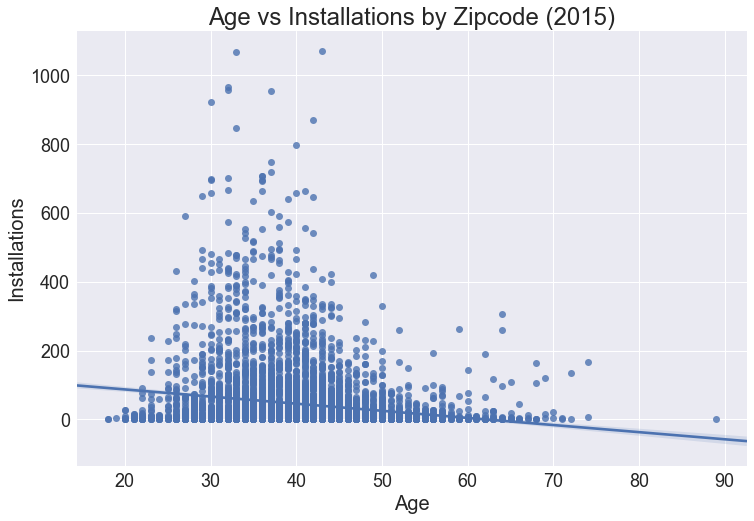

In [30]:
#plot scatter plot for age vs installations
plt.figure(figsize=(12,8))
#plt.scatter(age_zip.astype(int),ins_counts_zip, label="2015 by zipcode")
ax = sns.regplot(x=age_zip.astype(int), y=ins_counts_zip)
#plt.xlim(0,2.6e7)
plt.xlabel('Age', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Installations', fontsize=20)
plt.yticks(fontsize=18)
plt.title('Age vs Installations by Zipcode (2015)', fontsize=24)
#plt.legend()
plt.show()

50.961063829787236
19.417818740399387


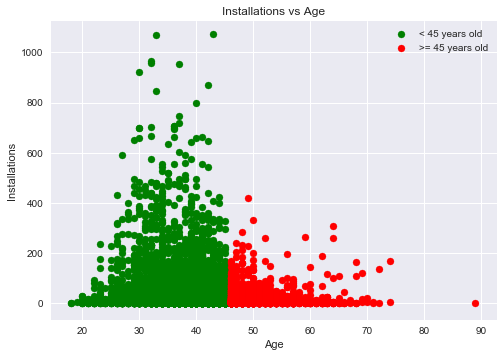

In [31]:
#Two subsets of the age group
df_zip_lt45=df_zip[df_zip['age']<=45]
df_zip_gt45=df_zip[df_zip['age']> 45]
#Mean values
mean_lt45=df_zip_lt45['ins counts'].mean()
mean_gt45=df_zip_gt45['ins counts'].mean()
print(mean_lt45)
print(mean_gt45)
# Plot the Data in groups
plt.scatter(df_zip_lt45['age'], df_zip_lt45['ins counts'], c="g", label="< 45 years old")
plt.scatter(df_zip_gt45['age'], df_zip_gt45['ins counts'], c="r", label=">= 45 years old")
plt.legend(loc="best")
plt.xlabel("Age")
plt.ylabel("Installations")
plt.title("Installations vs Age")
plt.show()

In [32]:
# Run 2-Sample T-Test
stats.ttest_ind(df_zip_lt45['ins counts'],df_zip_gt45['ins counts'], equal_var=False)

Ttest_indResult(statistic=17.174304560603659, pvalue=2.0069322358745673e-64)

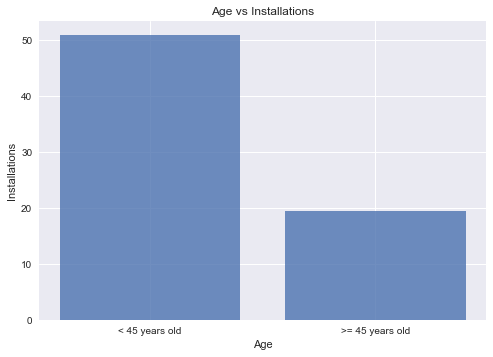

In [33]:
#Plot bar graph for mean installations vs age
tick_locations = [value+0.4 for value in range(2)]
plt.xticks(tick_locations, ['< 45 years old', '>= 45 years old'])
plt.bar(range(2),[mean_lt45,mean_gt45], alpha=0.8, align='edge')
plt.title("Age vs Installations")
plt.xlabel("Age")
plt.ylabel("Installations")
plt.show()
#plt.savefig('income_vs_counts'

<h2>Income Analysis</h2>

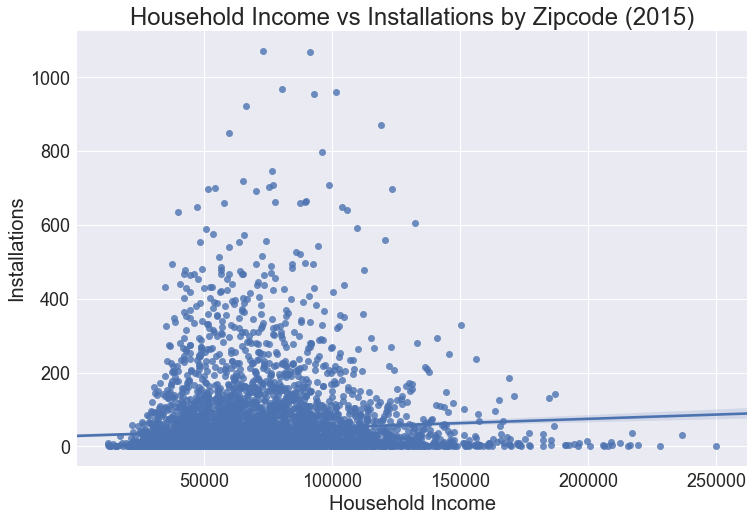

In [34]:
#plot income vs ins counts by zipcode
plt.figure(figsize=(12,8))
ax = sns.regplot(x=income_zip.astype(int), y=ins_counts_zip)
#plt.xlim(0,2.6e7)
plt.xlabel('Household Income', fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Installations', fontsize=20)
plt.yticks(fontsize=18)
plt.title('Household Income vs Installations by Zipcode (2015)', fontsize=24)
#plt.legend()
plt.show()

In [35]:
#Three subsets of the income group
df_zip_lt40k=df_zip[df_zip['household income']< 40000]
df_zip_40k_120k=df_zip[(df_zip['household income']>= 40000) & (df_zip['household income'] < 120000)]
df_zip_gt120k=df_zip[df_zip['household income']>= 120000]

mean_lt40k_ic=df_zip_lt40k['ins counts'].mean()
mean_40k_120K_ic=df_zip_40k_120k['ins counts'].mean()
mean_gt120k_ic=df_zip_gt120k['ins counts'].mean()
print(mean_lt40k_ic)
print(mean_40k_120K_ic)
print(mean_gt120k_ic)

24.763736263736263
47.14571140262361
41.26645768025078


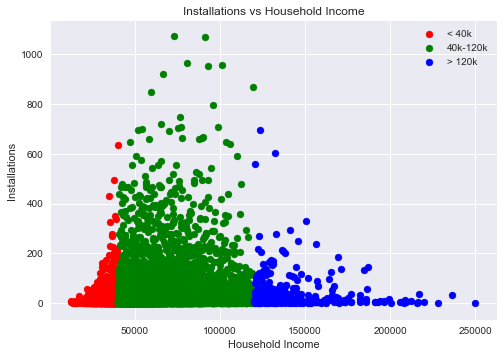

In [36]:
# Plot the income vs counts data
plt.scatter(df_zip_lt40k['household income'], df_zip_lt40k['ins counts'], c="r", label="< 40k")
plt.scatter(df_zip_40k_120k['household income'], df_zip_40k_120k['ins counts'], c="g", label="40k-120k")
plt.scatter(df_zip_gt120k['household income'], df_zip_gt120k['ins counts'], c="b", label="> 120k")
plt.legend(loc="best")
plt.xlabel("Household Income")
plt.ylabel("Installations")
plt.title("Installations vs Household Income")
plt.show()

In [37]:
# Perform the ANOVA
anova_income=stats.f_oneway(df_zip_lt40k['ins counts'],df_zip_40k_120k['ins counts'],df_zip_gt120k['ins counts'])
anova_income

F_onewayResult(statistic=18.777882919096719, pvalue=7.4180535270863943e-09)

In [38]:
gp1=df_zip_lt40k['ins counts']
gp2=df_zip_40k_120k['ins counts']
gp3=df_zip_gt120k['ins counts']

In [39]:
# Run 2-Sample T-Test
ttest_income1=stats.ttest_ind(gp1,gp2, equal_var=False)
ttest_income1

Ttest_indResult(statistic=-8.9803611202683413, pvalue=8.0309878551985174e-19)

In [40]:
ttest_income2=stats.ttest_ind(gp2,gp3, equal_var=False)
ttest_income2

Ttest_indResult(statistic=1.2590964459819312, pvalue=0.2087646463966191)

In [41]:
ttest_income3=stats.ttest_ind(gp1,gp3, equal_var=False)
ttest_income3

Ttest_indResult(statistic=-3.3552797709565199, pvalue=0.00085836787278917336)

In [42]:
#Generate a dataframe to summarize the stats results for the household income analysis
income_gps=['< 40k','40-120k','> 120k']
stat_tests_ic=['ANOVA', "2-Sample T-Test", "2-Sample T-Test", "2-Sample T-Test"]
groups_ic=['<40k, 40-120k, >120k','<40k vs 40-120k', '<40-120k vs >120k', '<40 vs >120k']
p_values_ic=[anova_income[1], ttest_income1[1],ttest_income2[1],ttest_income3[1]]

stat_income=pd.DataFrame({"Stat Test": stat_tests_ic, "Groups": groups_ic, "p Value": p_values_ic})
stat_income=stat_income[['Stat Test','Groups','p Value']]
stat_income['p Value']=stat_income['p Value'].round(2)
stat_income

,Stat Test,Groups,p Value
0,ANOVA,"<40k, 40-120k, >120k",0.00
1,2-Sample T-Test,<40k vs 40-120k,0.00
2,2-Sample T-Test,<40-120k vs >120k,0.21
3,2-Sample T-Test,<40 vs >120k,0.00


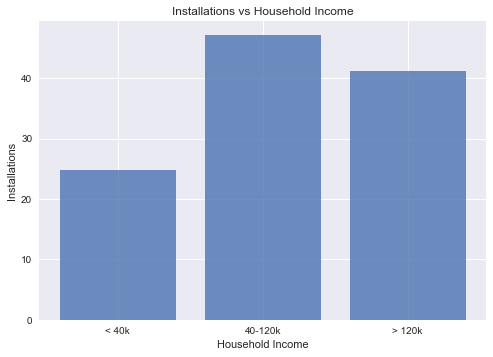

In [43]:
#Plot bar graph for the mean counts vs income groups
tick_locations = [value+0.4 for value in range(3)]
plt.xticks(tick_locations, income_gps)
plt.bar(range(3),[mean_lt40k_ic,mean_40k_120K_ic,mean_gt120k_ic], alpha=0.8, align='edge')
plt.xlabel("Household Income")
plt.ylabel("Installations")
plt.title("Installations vs Household Income")
plt.show()
#plt.savefig('income_vs_counts')